# Boundary conditions (Python interface)
## Demo for usage of *tools/boundaryHelper.py*

open-Qmin allows you to specify, site-by-site, the geometry and anchoring conditions of boundaries (including colloidal particles). This information is stored in an external *.txt* file that you can import into open-Qmin with the `--boundaryFile` command-line flag (without needing to recompile open-Qmin).

This Jupyter notebook demonstrates the use of *tools/boundaryHelper.py* to create a boundaryFile for open-Qmin through a pure-Python interface. 

Before getting started, let's make sure we have matplotlib and its Jupyter interface: 

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip     > /dev/null
!{sys.executable} -m pip install matplotlib ipympl > /dev/null

Now let's import what we need. You may need to change the path to the *boundaryHelper.py* file in your setup.

In [2]:
import numpy as np
from sys import path
path.append("../tools")  # path to boundaryHelper.py
import boundaryHelper as bh

## Example 1: One spherical colloid from user-supplied functions

To demonstrate usage with user-supplied custom functions, we'll start with a simple example of a single spherical colloid with homeotropic (perpendicular) anchoring.

The first step is always to make a `Scene`.

In [3]:
Lx = 50
Ly = 50
Lz = 50
sc = bh.Scene(Lx, Ly, Lz)

Then we need to define an anchoring condition. Our choices are

* `OrientedAnchoringCondition`: for homeotropic, oriented planar, etc.
* `DegeneratePlanarAnchoringCondition`: for degenerate planar.

We need to supply an anchoring strength and the value of $S_0$ (nematic degree of order) preferred at the surface.

In [4]:
ac = bh.OrientedAnchoringCondition(strength=5.3, S0=0.53)

Now we assign our anchoring condition as the anchoring condition of a `BoundaryObject`.

In [5]:
bo = bh.BoundaryObject(ac)

For any `BoundaryObject`, we need to define a function `member_func` that maps positions `X, Y, Z` to `True` if a site is part of the object, `False` otherwise. 

Note that `X, Y, Z` are three one-dimensional NumPy arrays of the same length.

In [6]:
# choose center of box as sphere center
Cx, Cy, Cz = np.array([(Lx - 1) / 2, (Ly - 1) / 2, (Lz - 1) / 2])
colloid_radius = 10


def sphere_member_func(X, Y, Z):
    return (X - Cx) ** 2 + (Y - Cy) ** 2 + (Z - Cz) ** 2 <= colloid_radius ** 2


bo.member_func = sphere_member_func

We also need to define a `normal_func` for the `BoundaryObject`, mapping positions `X, Y, Z` to the surface's outward normal vector (that is, facing into the nematic). 

The normal vectors don't need to be normalized. The formula only needs to be valid at the surface of the object, since the values for interior sites are not used. For oriented anchoring that isn't strictly homeotropic (perpendicular), we can supply the preferred direction as `normal_func` regardless of the true surface normal.

In [7]:
def sphere_normal_func(X, Y, Z):
    return (X - Cx, Y - Cy, Z - Cz)


bo.normal_func = sphere_normal_func

Lastly, we add our `BoundaryObject` to the `Scene` and instruct the `Scene` to create our boundaryFile.

In [8]:
sc.boundary_objects.append(bo)
sc.to_file("../one_spherical_colloid.txt")

Now you can `cd` back into the open-Qmin main directory and use the file as 

    build/openQmin.out -l 50 --boundaryFile one_spherical_colloid.txt ...
    
You may have to prefix the file name with a path to the file, of course.

The whole operation looks like this:

In [9]:
import numpy as np
from sys import path
path.append("../tools")  # path to boundaryHelper.py
import boundaryHelper as bh

Lx = 50
Ly = 50
Lz = 50
sc = bh.Scene(Lx, Ly, Lz)
ac = bh.OrientedAnchoringCondition(strength=5.3, S0=0.53)
bo = bh.BoundaryObject(ac)
# choose center of box as sphere center
Cx, Cy, Cz = np.array([(Lx - 1) / 2, (Ly - 1) / 2, (Lz - 1) / 2])
colloid_radius = 10


def sphere_member_func(X, Y, Z):
    return (X - Cx) ** 2 + (Y - Cy) ** 2 + (Z - Cz) ** 2 <= colloid_radius ** 2


bo.member_func = sphere_member_func


def sphere_normal_func(X, Y, Z):
    return (X - Cx, Y - Cy, Z - Cz)


bo.normal_func = sphere_normal_func
sc.boundary_objects.append(bo)
sc.to_file("../one_spherical_colloid.txt")

## Example 2: Using pre-defined boundary objects

*boundaryHelper.py* has a small number of `BoundaryObject` sub-classes with the `member_func` and `normal_func` calculated automatically from the supplied arguments. These include

* `SphericalColloid(anchoring_condition, center, radius)`
* `Wall(anchoring_condition, normal_direction, height)`
* `SphericalDroplet(anchoring_condition, radius)`
* `CylindricalCapillary(anchoring_condition, radius)`

Here's an example `Scene` with one homeotropic-anchoring `SphericalColloid` and one `Wall` with degenerate planar anchoring. Because of periodic boundary conditions for the simulation box, a single wall functions as both floor and ceiling.

In [10]:
sc = bh.Scene(50, 50, 50)
anch1 = bh.OrientedAnchoringCondition(strength=5.3, S0=0.53)
co = bh.SphericalColloid(anch1, (24, 24, 24), 10)
anch2 = bh.DegeneratePlanarAnchoringCondition(strength=10, S0=0.53)
wall = bh.Wall(anch2, "x", 5)  # normal to x, positioned at x=5
sc.boundary_objects = [co, wall]
sc.to_file("../sphere_and_wall.txt")

## Example 3: User-defined surface from height function

Here we're going to make two boundaries, a floor and a ceiling, with different shapes and anchoring conditions. (Note that when the floor and ceiling share the same shape and anchoring condition, we can use a single boundary object to represent them both. That's not the case here.) 

The ceiling will be a simple plane with degenerate planar anchoring condition. The floor, with homeotropic anchoring, will be an "egg-crate" surface defined by a height function $z=f(x,y) = A(\sin^2(q x) + \sin^2(q y))$ where $A$ is an amplitude and $q$ the wavenumber.

Here's a plot of the shape we want for the floor.

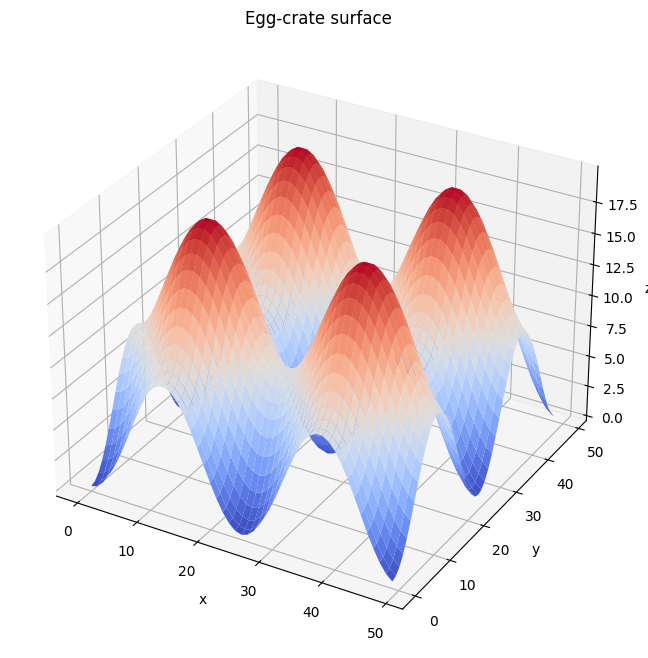

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Lx = Ly = Lz = 50
wave_amplitude = 10
wavelength = 50
wavenumber = 2 * np.pi / wavelength


def egg_crate_z(x, y):
    return wave_amplitude * (np.sin(wavenumber * x) ** 2 + np.sin(wavenumber * y) ** 2)


Xsurf, Ysurf = np.meshgrid(np.arange(Lx), np.arange(Ly))
Zsurf = egg_crate_z(Xsurf, Ysurf)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Xsurf, Ysurf, Zsurf, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Egg-crate surface")
plt.show()

And here's the code to make this surface a boundary condition for open-Qmin.

In [12]:
sc = bh.Scene(Lx, Ly, Lz)
anch1 = bh.OrientedAnchoringCondition(strength=5.3, S0=0.53)
wavy_floor = bh.BoundaryObject(anch1)


def wavy_floor_member_func(X, Y, Z):
    return Z < egg_crate_z(X, Y)


def wavy_floor_normal_func(X, Y, Z):
    ones = np.ones_like(X)
    # take gradient of function f(x,y,z) = z - zfunc(x,y), where f=0 defines surface
    return (
        -2
        * wave_amplitude
        * wavenumber
        * np.sin(wavenumber * X)
        * np.cos(wavenumber * X),
        -2
        * wave_amplitude
        * wavenumber
        * np.sin(wavenumber * Y)
        * np.cos(wavenumber * Y),
        np.ones_like(Z),
    )


wavy_floor.member_func = wavy_floor_member_func
wavy_floor.normal_func = wavy_floor_normal_func

anch2 = bh.DegeneratePlanarAnchoringCondition(strength=5.3, S0=0.53)
ceiling = bh.Wall(anch2, "z", Lz - 1)
sc.boundary_objects = [wavy_floor, ceiling]
sc.to_file("../ceiling_and_wavy_floor.txt")